In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

# Configuration
API_URL = "https://resensys.net:8443/api/v2/registration"
LOGIN_URL = "https://resensys.net:8443/login/"
DATA_ACQUIRE_URL = "https://resensys.net:8443/api/v1/data_acquire"
USERNAME = "Civionics_AI_Demo"
PASSWORD = "GIaP0A5wA1L4"
RESAMPLE_INTERVAL = '5min'

class ResensysDataFetcher:
    def __init__(self):
        self.session = requests.Session()

    def login(self):
        print("Attempting to log in...")
        response = self.session.get(LOGIN_URL)
        csrf_token = self.session.cookies.get('csrftoken')
        login_data = {
            "username": USERNAME,
            "password": PASSWORD,
            "csrfmiddlewaretoken": csrf_token
        }
        headers = {"Referer": LOGIN_URL}
        response = self.session.post(LOGIN_URL, data=login_data, headers=headers)
        if response.status_code != 200:
            raise Exception("Login failed")
        print("Login successful")

    def fetch_registered_devices(self):
        print("Fetching registered devices...")
        payload = {"username": USERNAME, "password": PASSWORD}
        response = self.session.post(API_URL, data=payload)
        if response.status_code != 200:
            raise Exception("Failed to fetch registered devices")
        return [device for _, device in response.json().items()]

    def fetch_device_data(self, device, start_date, end_date):
        """Fetch data for a single device over multiple weeks"""
        print(f"Fetching data for device SID: {device['SID']} ({device['QuantityName']})")
        start_dt = datetime.strptime(start_date, "%Y-%m-%d")
        end_dt = datetime.strptime(end_date, "%Y-%m-%d")
        all_data = pd.DataFrame()

        total_weeks = (end_dt - start_dt).days // 7 + 1
        current_start = start_dt

        with tqdm(total=total_weeks, desc=f"Fetching {device['QuantityName']}") as pbar:
            while current_start < end_dt:
                next_week = current_start + timedelta(weeks=1)
                current_end = min(next_week, end_dt)

                payload = {
                    "username": USERNAME,
                    "password": PASSWORD,
                    "SID": device["SID"],
                    "DID": device["DID"],
                    "DF": device["DataFormat"],
                    "T_start": current_start.strftime("%Y-%m-%d %H:%M:%S"),
                    "T_end": current_end.strftime("%Y-%m-%d %H:%M:%S"),
                    "csrfmiddlewaretoken": self.session.cookies.get('csrftoken')
                }

                response = self.session.post(DATA_ACQUIRE_URL, data=payload, headers={"Referer": DATA_ACQUIRE_URL})

                if response.status_code == 200:
                    try:
                        data = response.json()
                        if data:
                            # Convert the data values to float
                            processed_data = []
                            for x, y in data.items():
                                processed_y = {k: float(v) if k != 'Time' else v for k, v in y.items()}
                                processed_data.append(processed_y)

                            week_data = pd.DataFrame(processed_data)
                            all_data = pd.concat([all_data, week_data], ignore_index=True)
                    except ValueError as e:
                        print(f"Error processing data: {e}")
                else:
                    print(f"Failed to fetch data for week {current_start} to {current_end}")

                current_start = next_week
                pbar.update(1)

        if not all_data.empty:
            numeric_columns = all_data.columns
            all_data[numeric_columns] = all_data[numeric_columns].astype(float)
            all_data['Time'] = pd.to_datetime(all_data['Time'], unit='s')
            all_data.set_index('Time', inplace=True)
            # Ensure all numeric columns are float type
            all_data = all_data.resample(RESAMPLE_INTERVAL).mean()
        else:
            print(f"No data available for {device['QuantityName']}")

        return all_data

    def process_devices(self, devices, start_date, end_date):
        print("Processing devices...")
        aggregated_data = {}

        for device in devices:
            try:
                quantity_name = device['QuantityName']
                if quantity_name in ["2DHRT_Pitch", "2DHRT_Roll", "Displacement", "Strain-xx-high_rate"]:
                    device_data = self.fetch_device_data(device, start_date, end_date)
                    if not device_data.empty:
                        # Rename the columns to the quantity name
                        device_data.columns = [f"{quantity_name}_{idx}" for idx in range(len(device_data.columns))]

                        if quantity_name not in aggregated_data:
                            aggregated_data[quantity_name] = device_data
                        else:
                            aggregated_data[quantity_name] = pd.concat([aggregated_data[quantity_name], device_data], axis=1)
            except Exception as e:
                print(f"Error processing device DID: {device['DID']}", e)
                continue

        # Aggregate each quantity's data separately
        aggregated_results = {}
        for quantity_name, data in aggregated_data.items():
            # Calculate mean values for each quantity
            mean_values = data.mean(axis=1).astype(float)
            aggregated_results[quantity_name] = pd.DataFrame(mean_values, columns=[quantity_name])

            # Save individual quantity data
            filename = f"aggregated_data_{quantity_name}.csv"
            aggregated_results[quantity_name].to_csv(filename)
            print(f"Data for {quantity_name} saved to '{filename}'")

        return aggregated_results

def main():
    fetcher = ResensysDataFetcher()
    start_date = "2024-02-14"
    end_date = "2025-01-05"

    try:
        fetcher.login()
        registered_devices = fetcher.fetch_registered_devices()
        aggregated_results = fetcher.process_devices(registered_devices, start_date, end_date)

        # # Optionally, combine all quantities into a single DataFrame
        # combined_data = pd.concat([df for df in aggregated_results.values()], axis=1)
        # combined_data.to_csv("combined_aggregated_data.csv")
        # print("Combined data saved to 'combined_aggregated_data.csv'")

    except Exception as e:
        print("Error:", e)

if __name__ == "__main__":
    main()

Attempting to log in...
Login successful
Fetching registered devices...
Processing devices...
Fetching data for device SID: 18-64 (2DHRT_Roll)


Fetching 2DHRT_Roll: 100%|██████████| 47/47 [00:17<00:00,  2.68it/s]


Fetching data for device SID: 18-64 (2DHRT_Pitch)


Fetching 2DHRT_Pitch: 100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Fetching data for device SID: 18-64 (2DHRT_Roll)


Fetching 2DHRT_Roll: 100%|██████████| 47/47 [00:13<00:00,  3.42it/s]


Fetching data for device SID: 18-64 (2DHRT_Pitch)


Fetching 2DHRT_Pitch: 100%|██████████| 47/47 [00:17<00:00,  2.63it/s]


Fetching data for device SID: 18-64 (2DHRT_Roll)


Fetching 2DHRT_Roll: 100%|██████████| 47/47 [00:18<00:00,  2.48it/s]


Fetching data for device SID: 18-64 (2DHRT_Pitch)


Fetching 2DHRT_Pitch: 100%|██████████| 47/47 [00:17<00:00,  2.66it/s]


Fetching data for device SID: 18-64 (2DHRT_Roll)


Fetching 2DHRT_Roll: 100%|██████████| 47/47 [00:33<00:00,  1.40it/s]


Fetching data for device SID: 18-64 (2DHRT_Pitch)


Fetching 2DHRT_Pitch: 100%|██████████| 47/47 [00:17<00:00,  2.62it/s]


Fetching data for device SID: 18-64 (Displacement)


Fetching Displacement: 100%|██████████| 47/47 [00:13<00:00,  3.38it/s]


Fetching data for device SID: 18-64 (Displacement)


Fetching Displacement: 100%|██████████| 47/47 [00:23<00:00,  2.04it/s]


Fetching data for device SID: 18-64 (Displacement)


Fetching Displacement: 100%|██████████| 47/47 [00:14<00:00,  3.35it/s]


Fetching data for device SID: 18-64 (Displacement)


Fetching Displacement: 100%|██████████| 47/47 [00:23<00:00,  2.02it/s]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:24<00:00,  1.79s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate:   0%|          | 0/47 [00:00<?, ?it/s]


Error processing device DID: 15-03-52-29 ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:32<00:00,  1.96s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:19<00:00,  1.70s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate:   0%|          | 0/47 [00:00<?, ?it/s]


Error processing device DID: 15-03-53-14 ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:18<00:00,  1.68s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:20<00:00,  1.70s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:36<00:00,  2.04s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate:   0%|          | 0/47 [00:00<?, ?it/s]


Error processing device DID: 15-03-53-19 ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:20<00:00,  1.72s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:25<00:00,  1.82s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:18<00:00,  1.67s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:19<00:00,  1.69s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:24<00:00,  1.80s/it]


Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate:   0%|          | 0/47 [00:00<?, ?it/s]


Error processing device DID: 15-03-53-26 ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
Fetching data for device SID: 18-64 (Strain-xx-high_rate)


Fetching Strain-xx-high_rate: 100%|██████████| 47/47 [01:24<00:00,  1.80s/it]


Data for 2DHRT_Roll saved to 'aggregated_data_2DHRT_Roll.csv'
Data for 2DHRT_Pitch saved to 'aggregated_data_2DHRT_Pitch.csv'
Data for Displacement saved to 'aggregated_data_Displacement.csv'
Data for Strain-xx-high_rate saved to 'aggregated_data_Strain-xx-high_rate.csv'


In [ ]:
%pip install pandas numpy scipy scikit-learn matplotlib tensorflow rainflow seaborn

In [ ]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.stats import skew, kurtosis
from rainflow import count_cycles
from statsmodels.tsa.seasonal import STL

# Configuration
SENSOR_FILES = ['aggregated_data_2DHRT_Pitch.csv', 'aggregated_data_2DHRT_Roll.csv', 'aggregated_data_Displacement.csv', 'aggregated_data_Strain-xx-high_rate.csv']
OUTPUT_FILE = "preprocessed_features.csv"  # File to save the feature-engineered data
RESAMPLE_INTERVAL = '5min'  # 5-minute intervals

# Function to load and process a single file
def process_file(file_path):
    df = pd.read_csv(file_path)
    value_column = [col for col in df.columns if col.lower() != 'time'][0]
    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)
    df = df.resample(RESAMPLE_INTERVAL).mean()
    z_scores = (df[value_column] - df[value_column].mean()) / df[value_column].std()
    df = df[np.abs(z_scores) < 3]

    def butter_lowpass_filter(data, cutoff=0.1, fs=1.0, order=2):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    df[value_column] = butter_lowpass_filter(df[value_column].fillna(0), cutoff=0.1, fs=1.0)
    return df

# Generate basic statistical features
def generate_statistical_features(df):
    features = pd.DataFrame(index=df.index)
    features['mean'] = df.mean(axis=1)
    features['std'] = df.std(axis=1)
    features['skew'] = df.apply(skew, axis=1)
    features['kurtosis'] = df.apply(kurtosis, axis=1)
    return features

# Generate dynamic rolling features
def generate_dynamic_features(df, window_size=12):
    features = pd.DataFrame(index=df.index)
    features['rolling_mean'] = df.rolling(window=window_size).mean().mean(axis=1)
    features['rolling_std'] = df.rolling(window=window_size).std().mean(axis=1)
    features['rolling_min'] = df.rolling(window=window_size).min().mean(axis=1)
    features['rolling_max'] = df.rolling(window=window_size).max().mean(axis=1)
    return features

# Compute correlation features
def generate_correlation_features(df):
    features = pd.DataFrame(index=df.index)
    corr_matrix = df.corr()
    for i, col1 in enumerate(df.columns):
        for j, col2 in enumerate(df.columns):
            if i < j:
                features[f'{col1}_vs_{col2}_corr'] = df[col1].rolling(12).corr(df[col2])
    return features

# Apply Rainflow Counting
def generate_rainflow_features(df):
    features = pd.DataFrame(index=df.index)
    for col in df.columns:
        cycles = count_cycles(df[col].dropna().values)
        features[f'{col}_rainflow_mean'] = np.mean([cycle[0] for cycle in cycles])
        features[f'{col}_rainflow_count'] = len(cycles)
    return features

# Apply STL Decomposition
def generate_stl_features(df):
    features = pd.DataFrame(index=df.index)
    # Calculate the period based on resampling interval
    period = int(24 * 60 / pd.Timedelta(RESAMPLE_INTERVAL).seconds / 60) # Assuming daily cycle

    # Ensure period is at least 2
    period = max(2, period)

    for col in df.columns:
        # Pass the calculated period to the STL function
        stl = STL(df[col].dropna(), period=period, seasonal=13)
        result = stl.fit()
        features[f'{col}_trend'] = result.trend
        features[f'{col}_seasonal'] = result.seasonal
        features[f'{col}_residual'] = result.resid
    return features

# Main processing loop
processed_dfs = []
for file in SENSOR_FILES:
    processed_df = process_file(file)
    processed_dfs.append(processed_df)

merged_data = pd.concat(processed_dfs, axis=1)
merged_data.columns = [f"Sensor_{i+1}" for i in range(len(processed_dfs))]
merged_data.dropna(inplace=True)

# Generate features
statistical_features = generate_statistical_features(merged_data)
dynamic_features = generate_dynamic_features(merged_data)
correlation_features = generate_correlation_features(merged_data)
rainflow_features = generate_rainflow_features(merged_data)
stl_features = generate_stl_features(merged_data)

# Combine all features
all_features = pd.concat([statistical_features, dynamic_features, correlation_features, rainflow_features, stl_features], axis=1)
all_features.dropna(inplace=True)

# Save features to file
all_features.to_csv(OUTPUT_FILE)
print(f"Feature engineering complete. Features saved to {OUTPUT_FILE}")


Feature engineering complete. Features saved to preprocessed_features.csv


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0909 - val_loss: 0.0296
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0293 - val_loss: 0.0155
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - val_loss: 0.0095
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - val_loss: 0.0080
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 - val_loss: 0.0062
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 - val_loss: 0.0047
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 - val_loss: 0.0032
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061 - val_loss: 0.0028
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051 - val_loss: 0.0022

473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014
Test Loss: 0.0014408057322725654


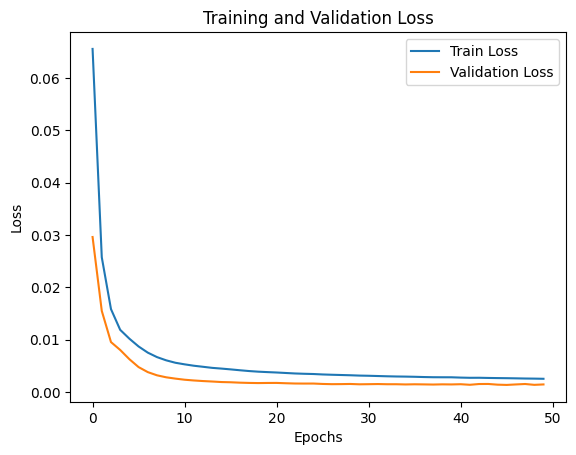

473/473 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Anomaly Detection Threshold: 0.003521377714347683
Number of anomalies detected: 608


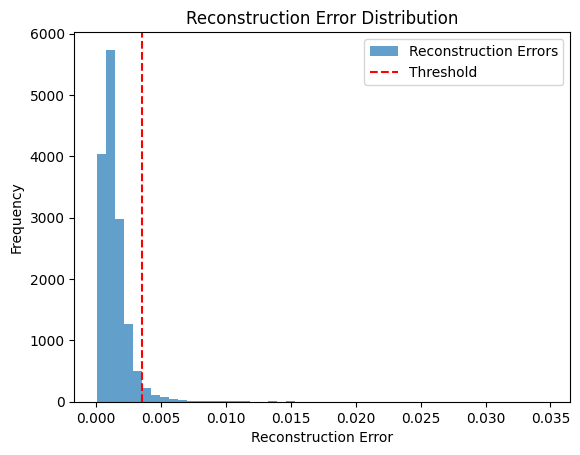

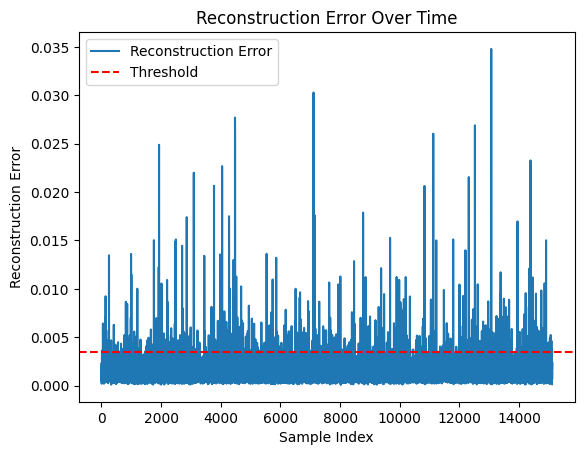

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Configuration
INPUT_FILE = "preprocessed_features.csv"  # File containing the feature-engineered data
EPOCHS = 50  # Number of training epochs
BATCH_SIZE = 1024  # Batch size for training
TEST_SIZE = 0.2  # Proportion of the dataset to include in the test split
VALIDATION_SPLIT = 0.1  # Proportion of training data for validation
THRESHOLD_FACTOR = 1.5  # Factor to scale the threshold for anomaly detection

# Load preprocessed features
data = pd.read_csv(INPUT_FILE, index_col=0)  # Load feature-engineered data from a CSV file

# Scale the data to [0, 1] range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split data into training and testing sets
X_train, X_test = train_test_split(data_scaled, test_size=TEST_SIZE, random_state=42)

# Define Autoencoder model
input_dim = X_train.shape[1]
model = Sequential([
    Dense(64, activation='relu', input_dim=input_dim),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse')

# Train the Autoencoder
history = model.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    shuffle=True
)

# Save the trained model
model.save("autoencoder_anomaly_detector.h5")

# Evaluate the model on the test set
loss = model.evaluate(X_test, X_test)
print(f"Test Loss: {loss}")

# Visualize training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Anomaly Detection: Reconstruction Errors
reconstructions = model.predict(X_test)
reconstruction_errors = np.mean(np.square(X_test - reconstructions), axis=1)

# Determine anomaly threshold
threshold = np.mean(reconstruction_errors) + THRESHOLD_FACTOR * np.std(reconstruction_errors)
print(f"Anomaly Detection Threshold: {threshold}")

# Classify anomalies based on the threshold
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualization 1: Reconstruction Error Distribution
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

# Visualization 2: Reconstruction Error over Time
plt.plot(range(len(reconstruction_errors)), reconstruction_errors, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time')
plt.legend()
plt.show()

1889/1889 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


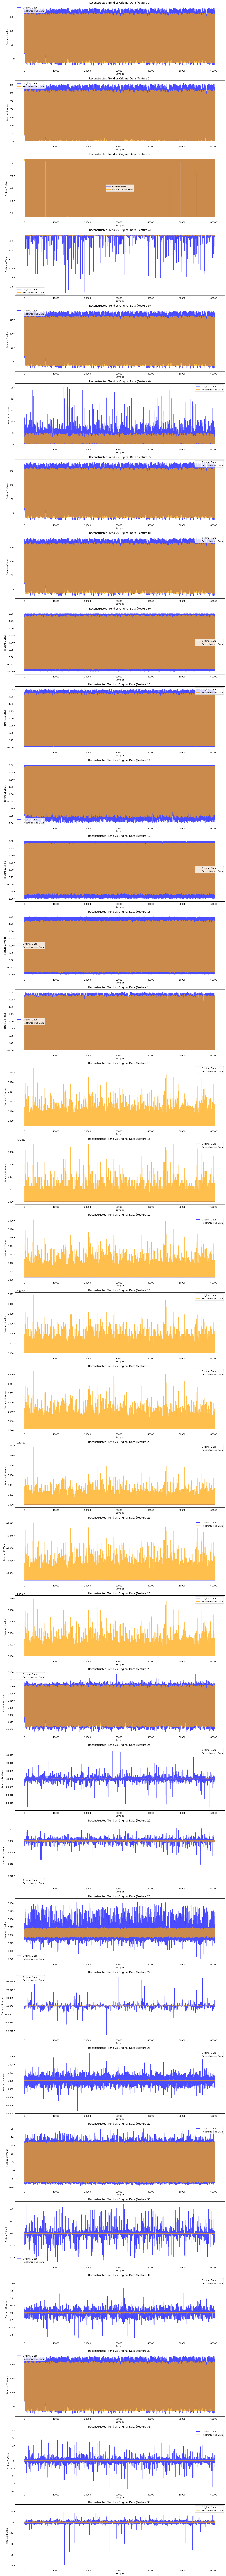

In [ ]:
# Visualize reconstructed trend vs original data for all features in the training set
X_train_reconstructed = model.predict(X_train)

# Reverse the scaling for better interpretability
X_train_original = scaler.inverse_transform(X_train)
X_train_reconstructed_original = scaler.inverse_transform(X_train_reconstructed)

# Create a plot for each feature
num_features = X_train_original.shape[1]

# Set up a figure with subplots
plt.figure(figsize=(15, 5 * num_features))

# Loop through each feature and generate a subplot
for feature_idx in range(num_features):
    plt.subplot(num_features, 1, feature_idx + 1)  # Create a subplot for each feature
    plt.plot(
        range(len(X_train_original)),
        X_train_original[:, feature_idx],
        label='Original Data',
        alpha=0.7,
        color='blue'
    )
    plt.plot(
        range(len(X_train_reconstructed_original)),
        X_train_reconstructed_original[:, feature_idx],
        label='Reconstructed Data',
        alpha=0.7,
        color='orange'
    )
    plt.xlabel('Samples')
    plt.ylabel(f'Feature {feature_idx + 1} Value')
    plt.title(f'Reconstructed Trend vs Original Data (Feature {feature_idx + 1})')
    plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


2361/2361 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Anomaly Detection Threshold: 1.1674230641209056
Number of anomalies detected: 180


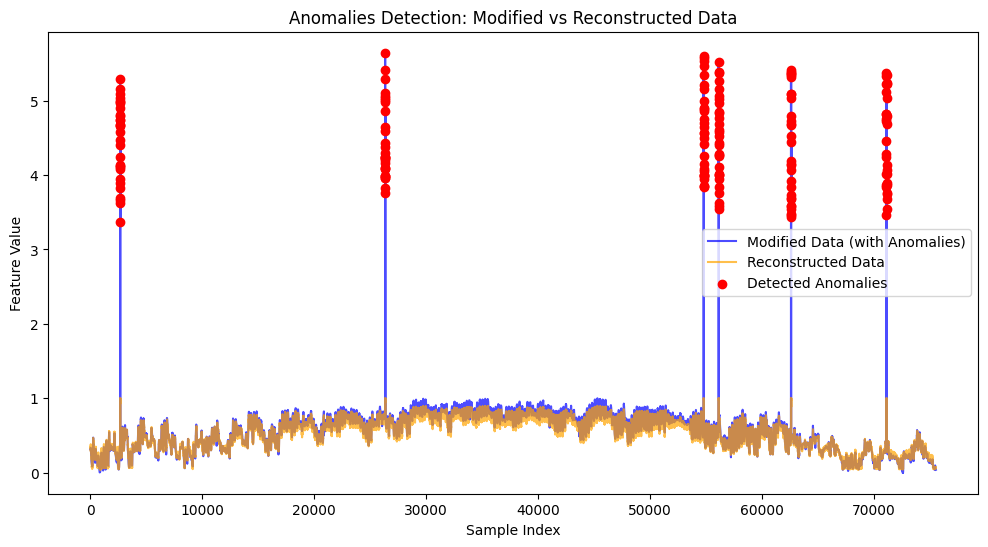

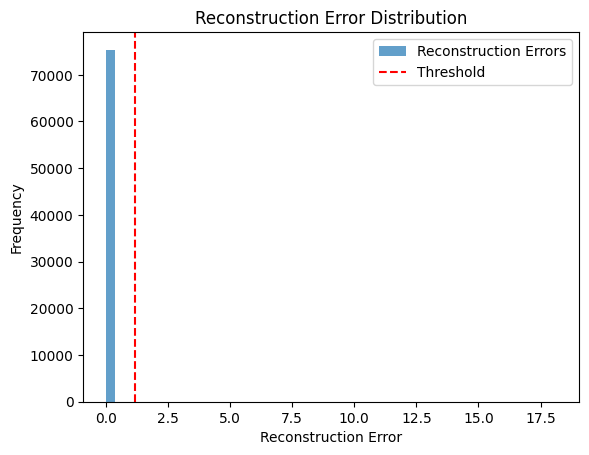

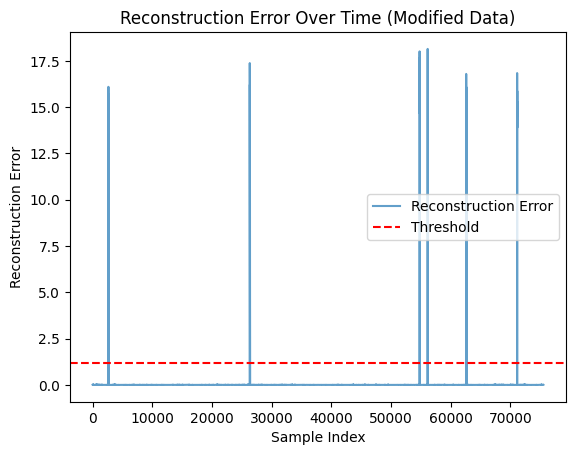

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Configuration
INPUT_FILE = "preprocessed_features.csv"  # File containing the feature-engineered data
THRESHOLD_FACTOR = 1.5  # Factor to scale the threshold for anomaly detection
ANOMALY_DURATION = 30  # Duration of anomalies in terms of time steps
ANOMALY_MAGNITUDE = 3  # Magnitude of the anomaly spikes

# Load preprocessed features
data = pd.read_csv(INPUT_FILE, index_col=0)  # Load feature-engineered data from a CSV file

# Scale the data to [0, 1] range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Split data into training and testing sets
X_train = data_scaled  # Use the entire dataset as training data to introduce anomalies
X_test = X_train  # In this case, we simulate anomalies in the training set itself

# Introduce time-based anomalies into the training data (spikes that happen over time)
num_anomalies = 6  # Number of anomaly events to create
for _ in range(num_anomalies):
    anomaly_start = np.random.randint(0, len(X_train) - ANOMALY_DURATION)  # Randomly select a start time
    anomaly_end = anomaly_start + ANOMALY_DURATION  # Define the end of the anomaly duration

    # Create spikes (anomalies) for a range of features
    anomaly_spike = np.random.uniform(ANOMALY_MAGNITUDE, ANOMALY_MAGNITUDE + 2, (anomaly_end - anomaly_start, X_train.shape[1]))

    # Add anomalies to the data (simulating spikes over time)
    X_train[anomaly_start:anomaly_end] += anomaly_spike

# Define the Autoencoder model (Assuming the model is already trained)
model = tf.keras.models.load_model("autoencoder_anomaly_detector.h5", compile=False)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Get the reconstructed data from the autoencoder
X_train_reconstructed = model.predict(X_train)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(X_train - X_train_reconstructed), axis=1)

# Determine anomaly threshold
threshold = np.mean(reconstruction_errors) + THRESHOLD_FACTOR * np.std(reconstruction_errors)
print(f"Anomaly Detection Threshold: {threshold}")

# Classify anomalies based on the threshold
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualization 1: Compare original, reconstructed, and modified data for the first feature
plt.figure(figsize=(12, 6))
plt.plot(range(len(X_train)), X_train[:, 0], label='Modified Data (with Anomalies)', alpha=0.7, color='blue')
plt.plot(range(len(X_train_reconstructed)), X_train_reconstructed[:, 0], label='Reconstructed Data', alpha=0.7, color='orange')

# Highlight anomalies in the modified data
plt.scatter(np.where(anomalies)[0], X_train[anomalies, 0], color='red', label='Detected Anomalies', zorder=5)

plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.title('Anomalies Detection: Modified vs Reconstructed Data')
plt.legend()
plt.show()

# Visualization 2: Reconstruction Error Distribution
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()

# Visualization 3: Reconstruction Error Over Time (Modified Data)
plt.plot(range(len(reconstruction_errors)), reconstruction_errors, label='Reconstruction Error', alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time (Modified Data)')
plt.legend()
plt.show()


2361/2361 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Anomaly Detection Threshold: 0.003458480673750944
Number of anomalies detected: 3120


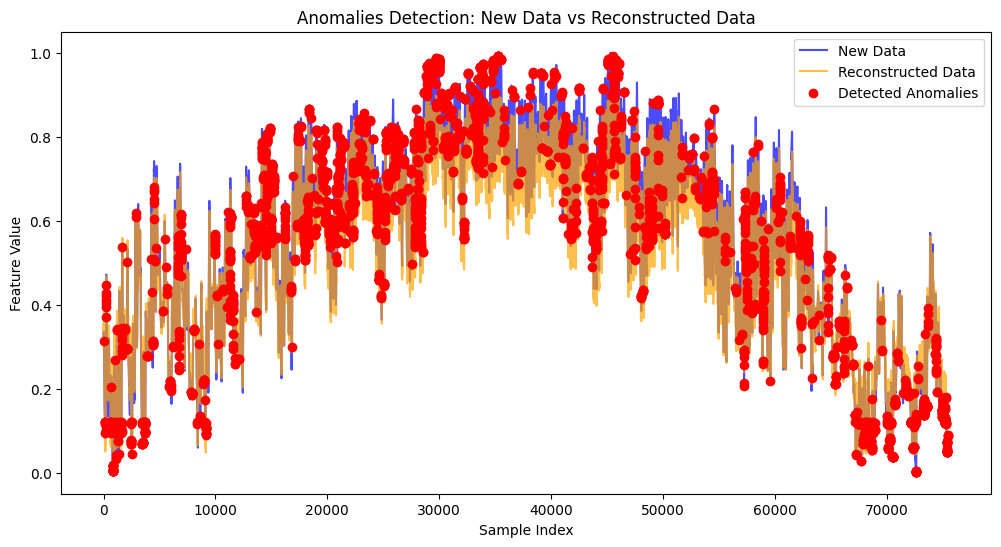

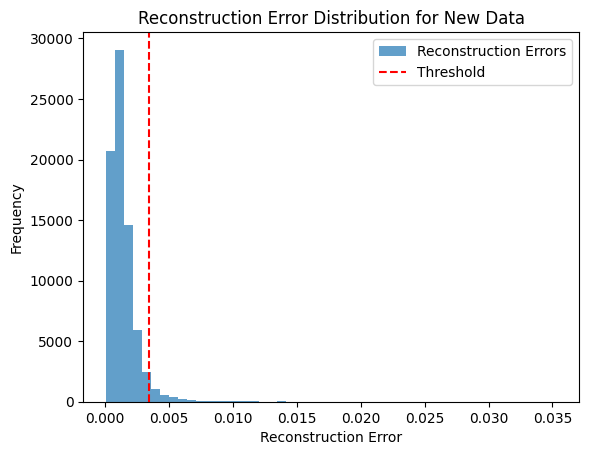

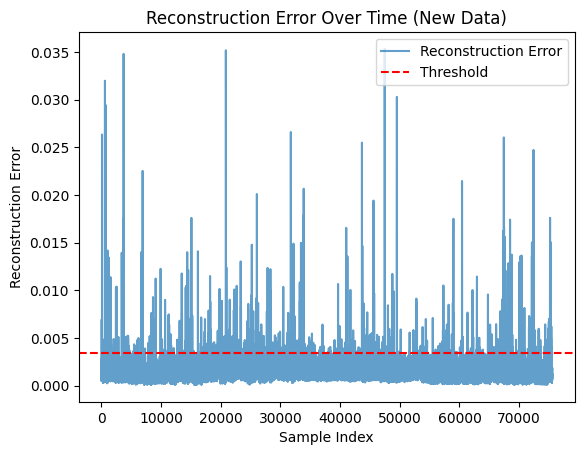

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Configuration
INPUT_FILE = "preprocessed_features.csv"  # File containing the new data to test the model on
THRESHOLD_FACTOR = 1.5  # Factor to scale the threshold for anomaly detection

# Load the new data
new_data = pd.read_csv(INPUT_FILE, index_col=0)  # Assuming the data has a Time column as the index

# Scale the new data using the same scaler that was used for the training data
new_data_scaled = scaler.transform(new_data)  # Use the same scaler to scale new data

# Define the Autoencoder model (Assuming the model is already trained)
model = tf.keras.models.load_model("autoencoder_anomaly_detector.h5", compile=False)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Get the reconstructed data from the autoencoder
new_data_reconstructed = model.predict(new_data_scaled)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(new_data_scaled - new_data_reconstructed), axis=1)

# Determine anomaly threshold
threshold = np.mean(reconstruction_errors) + THRESHOLD_FACTOR * np.std(reconstruction_errors)
print(f"Anomaly Detection Threshold: {threshold}")

# Classify anomalies based on the threshold
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# Visualization 1: Compare original, reconstructed, and new data for the first feature
plt.figure(figsize=(12, 6))
plt.plot(range(len(new_data_scaled)), new_data_scaled[:, 0], label='New Data', alpha=0.7, color='blue')
plt.plot(range(len(new_data_reconstructed)), new_data_reconstructed[:, 0], label='Reconstructed Data', alpha=0.7, color='orange')

# Highlight anomalies in the new data
plt.scatter(np.where(anomalies)[0], new_data_scaled[anomalies, 0], color='red', label='Detected Anomalies', zorder=5)

plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.title('Anomalies Detection: New Data vs Reconstructed Data')
plt.legend()
plt.show()

# Visualization 2: Reconstruction Error Distribution for New Data
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution for New Data')
plt.legend()
plt.show()

# Visualization 3: Reconstruction Error Over Time (New Data)
plt.plot(range(len(reconstruction_errors)), reconstruction_errors, label='Reconstruction Error', alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time (New Data)')
plt.legend()
plt.show()


2361/2361 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


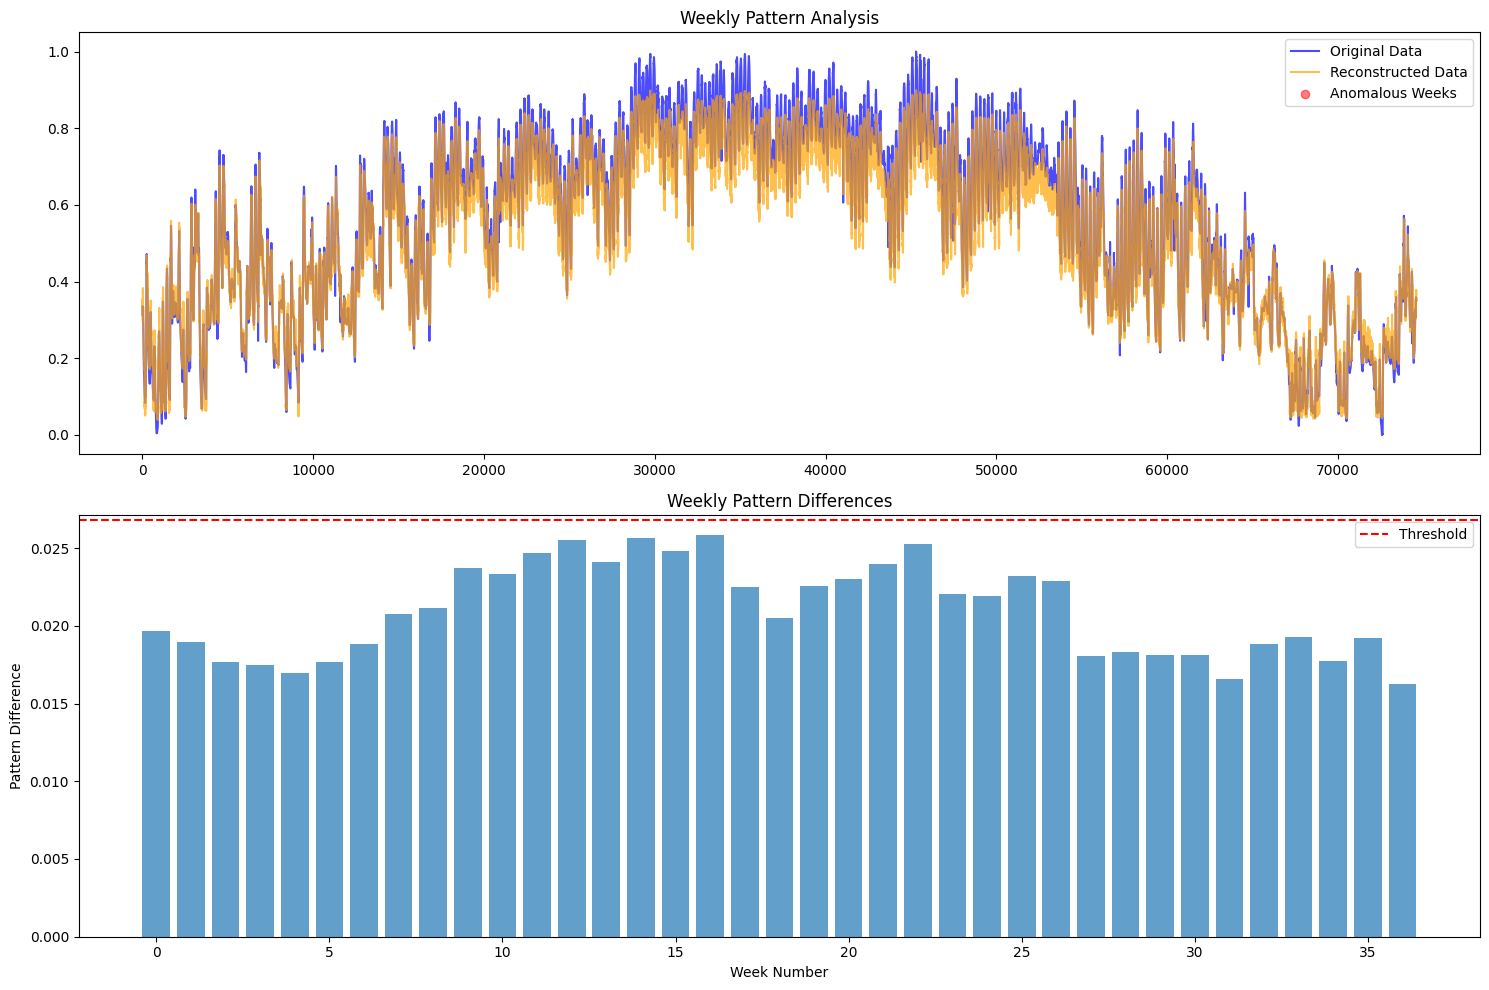

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Calculate samples per week (7 days * 24 hours * 12 samples per hour)
SAMPLES_PER_WEEK = 7 * 24 * 12

def analyze_weekly_patterns(data_scaled, reconstructed_data):
    # Reshape data into weeks
    num_complete_weeks = len(data_scaled) // SAMPLES_PER_WEEK

    # Truncate data to complete weeks
    truncated_length = num_complete_weeks * SAMPLES_PER_WEEK
    data_weeks = data_scaled[:truncated_length].reshape(num_complete_weeks, SAMPLES_PER_WEEK, -1)
    reconstructed_weeks = reconstructed_data[:truncated_length].reshape(num_complete_weeks, SAMPLES_PER_WEEK, -1)

    # Calculate weekly pattern similarity
    weekly_differences = []
    for week in range(num_complete_weeks):
        # Calculate pattern difference for the week
        week_diff = np.mean(np.abs(data_weeks[week] - reconstructed_weeks[week]))
        weekly_differences.append(week_diff)

    # Convert to array and identify anomalous weeks
    weekly_differences = np.array(weekly_differences)
    threshold = np.mean(weekly_differences) + (2 * np.std(weekly_differences))
    anomalous_weeks = weekly_differences > threshold

    # Convert weekly anomalies back to original time series
    anomalies = np.repeat(anomalous_weeks, SAMPLES_PER_WEEK)

    return anomalies, weekly_differences, threshold

# Load and process your data as before
INPUT_FILE = "preprocessed_features.csv"
new_data = pd.read_csv(INPUT_FILE, index_col=0)
new_data_scaled = scaler.transform(new_data)

# Load and predict with model
model = tf.keras.models.load_model("autoencoder_anomaly_detector.h5", compile=False)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
new_data_reconstructed = model.predict(new_data_scaled)

# Detect weekly pattern anomalies
anomalies, weekly_differences, threshold = analyze_weekly_patterns(new_data_scaled, new_data_reconstructed)

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Original vs Reconstructed with Weekly Anomalies
plt.subplot(2, 1, 1)
plt.plot(new_data_scaled[:len(anomalies), 0], label='Original Data', alpha=0.7, color='blue')
plt.plot(new_data_reconstructed[:len(anomalies), 0], label='Reconstructed Data', alpha=0.7, color='orange')

# Highlight anomalous weeks
anomaly_indices = np.where(anomalies)[0]
plt.scatter(anomaly_indices, new_data_scaled[anomaly_indices, 0],
           color='red', label='Anomalous Weeks', alpha=0.5)

plt.title('Weekly Pattern Analysis')
plt.legend()

# Plot 2: Weekly Pattern Differences
plt.subplot(2, 1, 2)
weeks = range(len(weekly_differences))
plt.bar(weeks, weekly_differences, alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Weekly Pattern Differences')
plt.xlabel('Week Number')
plt.ylabel('Pattern Difference')
plt.legend()

plt.tight_layout()
plt.show()

2361/2361 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


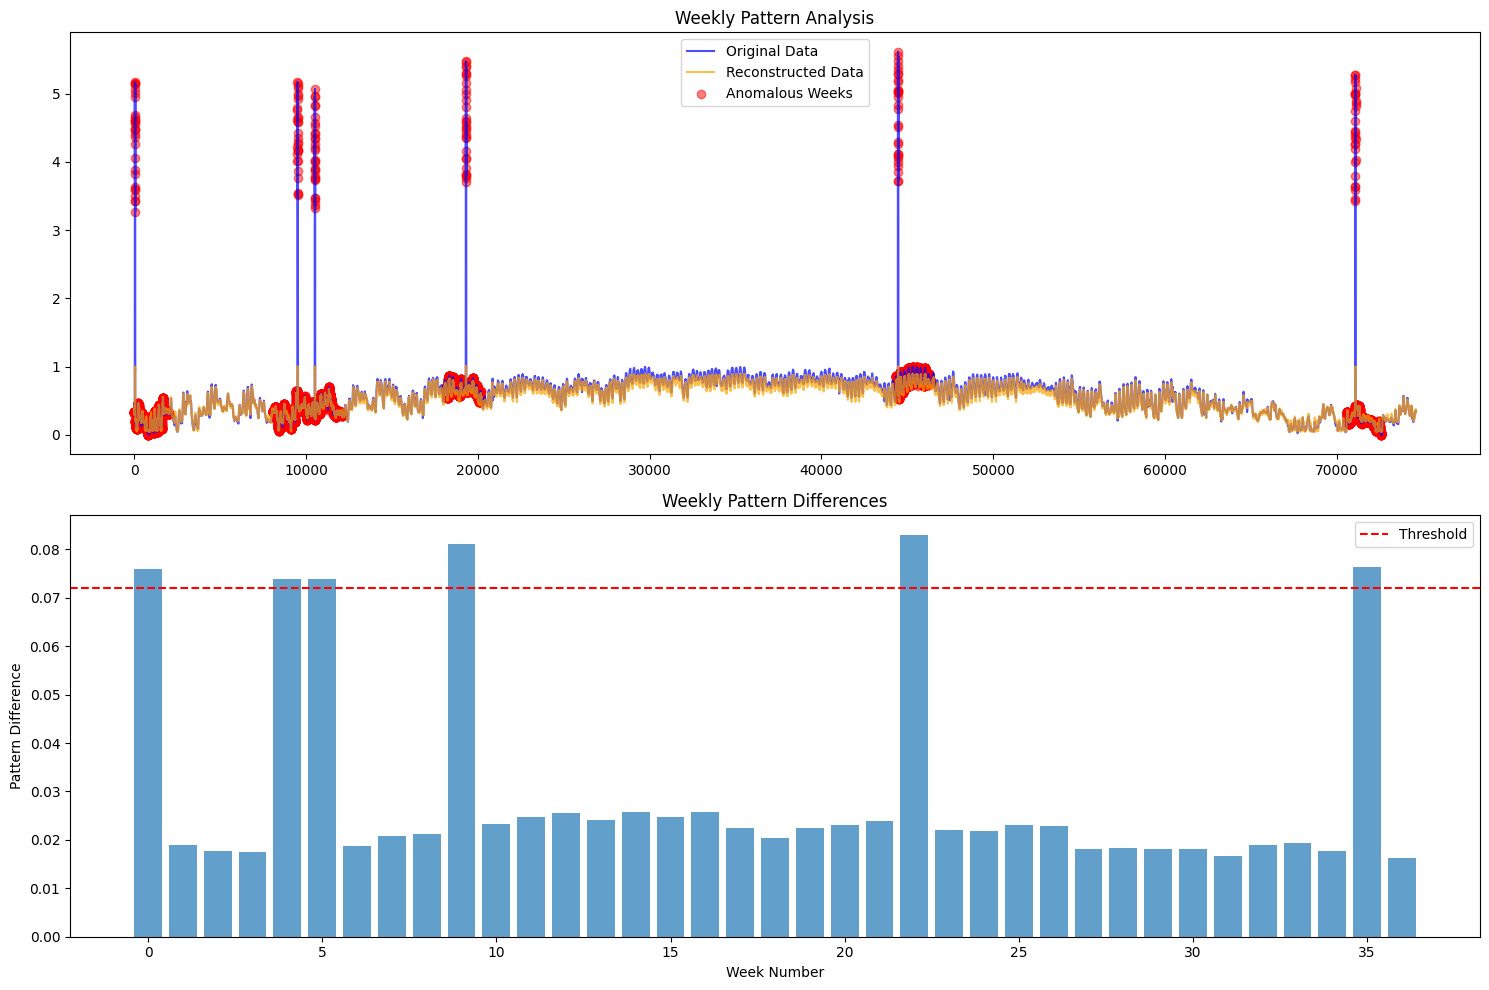

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Calculate samples per week (7 days * 24 hours * 12 samples per hour)
SAMPLES_PER_WEEK = 7 * 24 * 12

def analyze_weekly_patterns(data_scaled, reconstructed_data):
    # Reshape data into weeks
    num_complete_weeks = len(data_scaled) // SAMPLES_PER_WEEK

    # Truncate data to complete weeks
    truncated_length = num_complete_weeks * SAMPLES_PER_WEEK
    data_weeks = data_scaled[:truncated_length].reshape(num_complete_weeks, SAMPLES_PER_WEEK, -1)
    reconstructed_weeks = reconstructed_data[:truncated_length].reshape(num_complete_weeks, SAMPLES_PER_WEEK, -1)

    # Calculate weekly pattern similarity
    weekly_differences = []
    for week in range(num_complete_weeks):
        # Calculate pattern difference for the week
        week_diff = np.mean(np.abs(data_weeks[week] - reconstructed_weeks[week]))
        weekly_differences.append(week_diff)

    # Convert to array and identify anomalous weeks
    weekly_differences = np.array(weekly_differences)
    threshold = np.mean(weekly_differences) + (2 * np.std(weekly_differences))
    anomalous_weeks = weekly_differences > threshold

    # Convert weekly anomalies back to original time series
    anomalies = np.repeat(anomalous_weeks, SAMPLES_PER_WEEK)

    return anomalies, weekly_differences, threshold

# Load and process your data as before
INPUT_FILE = "preprocessed_features.csv"
new_data = pd.read_csv(INPUT_FILE, index_col=0)
# Split data into training and testing sets

new_data_scaled = scaler.transform(new_data)
X_train = new_data_scaled  # Use the entire dataset as training data to introduce anomalies
X_test = X_train  # In this case, we simulate anomalies in the training set itself

# Introduce time-based anomalies into the training data (spikes that happen over time)
num_anomalies = 6  # Number of anomaly events to create
for _ in range(num_anomalies):
    anomaly_start = np.random.randint(0, len(X_train) - ANOMALY_DURATION)  # Randomly select a start time
    anomaly_end = anomaly_start + ANOMALY_DURATION  # Define the end of the anomaly duration

    # Create spikes (anomalies) for a range of features
    anomaly_spike = np.random.uniform(ANOMALY_MAGNITUDE, ANOMALY_MAGNITUDE + 2, (anomaly_end - anomaly_start, X_train.shape[1]))

    # Add anomalies to the data (simulating spikes over time)
    X_train[anomaly_start:anomaly_end] += anomaly_spike
# Load and predict with model
model = tf.keras.models.load_model("autoencoder_anomaly_detector.h5", compile=False)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
new_data_reconstructed = model.predict(X_train)

# Detect weekly pattern anomalies
anomalies, weekly_differences, threshold = analyze_weekly_patterns(new_data_scaled, new_data_reconstructed)

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Original vs Reconstructed with Weekly Anomalies
plt.subplot(2, 1, 1)
plt.plot(new_data_scaled[:len(anomalies), 0], label='Original Data', alpha=0.7, color='blue')
plt.plot(new_data_reconstructed[:len(anomalies), 0], label='Reconstructed Data', alpha=0.7, color='orange')

# Highlight anomalous weeks
anomaly_indices = np.where(anomalies)[0]
plt.scatter(anomaly_indices, new_data_scaled[anomaly_indices, 0],
           color='red', label='Anomalous Weeks', alpha=0.5)

plt.title('Weekly Pattern Analysis')
plt.legend()

# Plot 2: Weekly Pattern Differences
plt.subplot(2, 1, 2)
weeks = range(len(weekly_differences))
plt.bar(weeks, weekly_differences, alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Weekly Pattern Differences')
plt.xlabel('Week Number')
plt.ylabel('Pattern Difference')
plt.legend()

plt.tight_layout()
plt.show()

2361/2361 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


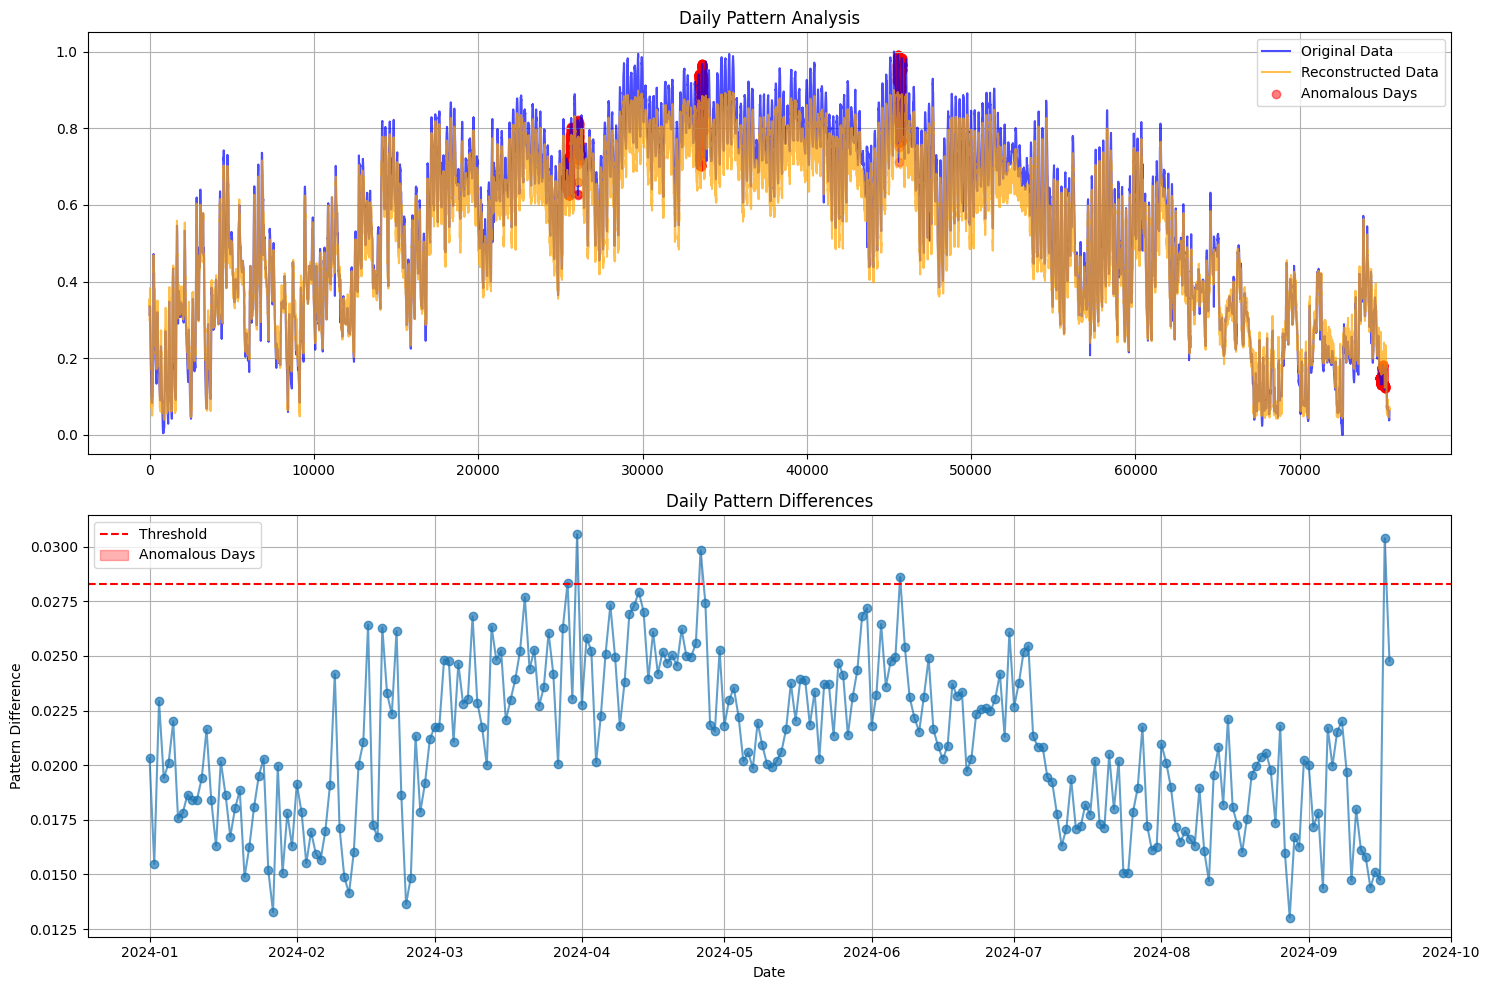

Total number of days analyzed: 262
Number of anomalous days detected: 5
Percentage of anomalous days: 1.91%


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Calculate samples per day (24 hours * 12 samples per hour for 5-minute intervals)
SAMPLES_PER_DAY = 24 * 12

def analyze_daily_patterns(data_scaled, reconstructed_data):
    # Reshape data into days
    num_complete_days = len(data_scaled) // SAMPLES_PER_DAY

    # Truncate data to complete days
    truncated_length = num_complete_days * SAMPLES_PER_DAY
    data_days = data_scaled[:truncated_length].reshape(num_complete_days, SAMPLES_PER_DAY, -1)
    reconstructed_days = reconstructed_data[:truncated_length].reshape(num_complete_days, SAMPLES_PER_DAY, -1)

    # Calculate daily pattern similarity
    daily_differences = []
    for day in range(num_complete_days):
        day_diff = np.mean(np.abs(data_days[day] - reconstructed_days[day]))
        daily_differences.append(day_diff)

    daily_differences = np.array(daily_differences)
    threshold = np.mean(daily_differences) + (2 * np.std(daily_differences))
    anomalous_days = daily_differences > threshold

    # Convert daily anomalies back to original time series
    anomalies = np.repeat(anomalous_days, SAMPLES_PER_DAY)

    return anomalies, daily_differences, threshold, anomalous_days

# Load and process data
INPUT_FILE = "preprocessed_features.csv"
new_data = pd.read_csv(INPUT_FILE, index_col=0)
new_data_scaled = scaler.transform(new_data)

# Load and predict with model
model = tf.keras.models.load_model("autoencoder_anomaly_detector.h5", compile=False)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
new_data_reconstructed = model.predict(new_data_scaled)

# Detect daily pattern anomalies
anomalies, daily_differences, threshold, anomalous_days = analyze_daily_patterns(new_data_scaled, new_data_reconstructed)

# Create date range for x-axis (assuming data starts at beginning of a day)
date_range = pd.date_range(start='2024-01-01', periods=len(daily_differences), freq='D')

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Original vs Reconstructed with Daily Anomalies
plt.subplot(2, 1, 1)
plt.plot(new_data_scaled[:len(anomalies), 0], label='Original Data', alpha=0.7, color='blue')
plt.plot(new_data_reconstructed[:len(anomalies), 0], label='Reconstructed Data', alpha=0.7, color='orange')

# Highlight anomalous days
anomaly_indices = np.where(anomalies)[0]
plt.scatter(anomaly_indices, new_data_scaled[anomaly_indices, 0],
           color='red', label='Anomalous Days', alpha=0.5)

plt.title('Daily Pattern Analysis')
plt.legend()
plt.grid(True)

# Plot 2: Daily Pattern Differences
plt.subplot(2, 1, 2)
plt.plot(date_range, daily_differences, marker='o', linestyle='-', alpha=0.7)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.fill_between(date_range, daily_differences, threshold,
                where=(daily_differences > threshold),
                color='red', alpha=0.3, label='Anomalous Days')

plt.title('Daily Pattern Differences')
plt.xlabel('Date')
plt.ylabel('Pattern Difference')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print summary statistics
num_anomalous_days = np.sum(anomalous_days)
total_days = len(daily_differences)
print(f"Total number of days analyzed: {total_days}")
print(f"Number of anomalous days detected: {num_anomalous_days}")
print(f"Percentage of anomalous days: {(num_anomalous_days/total_days)*100:.2f}%")

In [ ]:
# Configuration
INPUT_FILE = "preprocessed_features.csv"  # File containing the new data
THRESHOLD_FACTOR = 30

# Load the entire dataset
data = pd.read_csv(INPUT_FILE, index_col=0)

# Calculate the start and end indices for the middle 1000 rows
total_rows = len(data)
start_index = (total_rows - 1000) // 2
end_index = start_index + 1000

# Select the middle 1000 rows
new_data = data.iloc[start_index:end_index]

# Scale the new data using the same scaler that was used for the training data
new_data_scaled = scaler.transform(new_data)  # Use the same scaler to scale new data

# Define the Autoencoder model (Assuming the model is already trained)
model = tf.keras.models.load_model("autoencoder_anomaly_detector.h5", compile=False)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Get the reconstructed data from the autoencoder
new_data_reconstructed = model.predict(new_data_scaled)

# Calculate reconstruction errors
reconstruction_errors = np.mean(np.square(new_data_scaled - new_data_reconstructed), axis=1)

# Determine anomaly threshold
threshold = np.mean(reconstruction_errors) + THRESHOLD_FACTOR * np.std(reconstruction_errors)
print(f"Anomaly Detection Threshold: {threshold}")

# Classify anomalies based on the threshold
anomalies = reconstruction_errors > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# ... (rest of the visualization code)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Anomaly Detection Threshold: 0.019303763577435042
Number of anomalies detected: 0
